In [1]:
import pandas, networkx as nx
import matplotlib.pyplot as plt
import json

Load node properties

In [2]:
fo = open('./traces/nodes.out', 'r')
data = fo.read()
fo.close()

In [3]:
dataset = json.loads(data)

In [72]:
locations = {}
for row in dataset['items']:
    if row['archi'] == 'm3:at86rf231' and row['x'] != ' ':
        addr = int(row['network_address'].split('.')[0].split('-')[1])
        #locations[addr] = (float(row['x']), float(row['y']), float(row['z']))
        locations[addr] = (float(row['x']), float(row['y']))

In [5]:
locations[97]

(17.9, 16.01, 6.1)

Import Node Ids and corresponding IPv6 addresses

In [77]:
addr = pandas.read_csv('./traces/addr-2019-01JAN-29-1.cap', 
                        sep='[ ;:/-]',                         
                        header=None, 
                        usecols=[2,23], 
                        names=['node_id', 'ipv6_addr'],                        
                        engine='python')

In [78]:
addr['node_id'] = addr['node_id'].convert_objects(convert_numeric=True)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [79]:
addr = addr.drop_duplicates(subset=['node_id'], keep="first").sort_values(by=['node_id'])

In [80]:
addr.set_index('node_id')

,ipv6_addr
node_id,
152,af32
154,ad22
155,ae22
156,8526
157,8936
171,8432
172,8826
173,ac52
174,af02


Build a look-up dictionary

In [81]:
ipv6 = {}
for index, row in addr.iterrows():
    ipv6[row['ipv6_addr']] = row['node_id']

Import RPL parents for each node

In [82]:
rpl = pandas.read_csv('./traces/rpl-2019-01JAN-29-1.cap', 
                        sep='[ ;:/-]',                         
                        header=None, 
                        usecols=[2,11], 
                        names=['node_id', 'rpl_parent'],                      
                        engine='python')

In [83]:
rpl['node_id'] = rpl['node_id'].convert_objects(convert_numeric=True)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [84]:
rpl = rpl.drop_duplicates(subset=['node_id', 'rpl_parent'], keep="first").sort_values(by=['node_id'])

In [85]:
rpl.set_index('node_id')

,rpl_parent
node_id,
152,8436
154,8436
155,8906
155,ac22
155,ad22
156,8906
156,af22
156,8c36
157,8426


Create a network

In [93]:
G = nx.DiGraph()

In [94]:
for index, row in addr.iterrows():    
    G.add_node(row['node_id'], addr=row['ipv6_addr'], loc=locations.get(row['node_id'], (0,0,0)))
    G.node[row['node_id']]['id'] = str(row['node_id'])
    G.node[row['node_id']]['color'] = 'blue'
    G.node[row['node_id']]['addr'] = row['ipv6_addr']
    G.node[row['node_id']]['loc'] = locations.get(row['node_id'], (0,0,0))    

In [95]:
G.node[252]['color'] = 'red'

In [96]:
for index, row in rpl.iterrows():
    if row['rpl_parent'] in ipv6 and row['node_id'] in G.nodes() and ipv6[row['rpl_parent']] in G.nodes():
        G.add_edge(row['node_id'], ipv6[row['rpl_parent']])

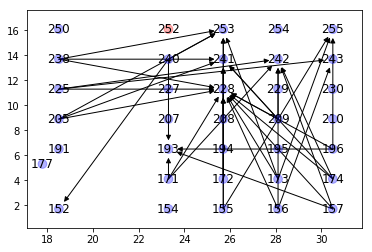

In [97]:
plt.clf()
nx.draw_networkx_nodes(G, pos=nx.get_node_attributes(G,'loc'), node_shape='.', node_color=list(nx.get_node_attributes(G,'color').values()), alpha=0.3)
nx.draw_networkx_labels(G, pos=nx.get_node_attributes(G,'loc'), labels=nx.get_node_attributes(G,'id'))
nx.draw_networkx_edges(G, pos=nx.get_node_attributes(G,'loc'))
plt.show()